In [1]:
import numpy as np
import pandas as pd


%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# create test df with continuous, categorical, and date/time vars
n = 1000
x1 = np.random.randn(n)
x2 = np.random.rand(n)


df = pd.DataFrame(
    {'x1':x1, 'x2':x2}
)

df.head()

,x1,x2
0,0.139588,0.245124
1,2.287860,0.893649
2,-0.737046,0.422728
3,-0.075140,0.520480
4,-1.067943,0.301647


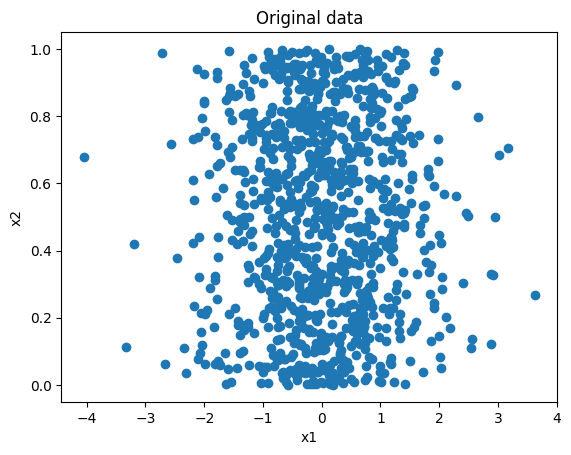

In [3]:
ax = plt.axes()
ax.scatter(df['x1'],df['x2'])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Original data')
plt.show()

In [4]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate
kde = KDEMultivariate(data=df, var_type='cc')

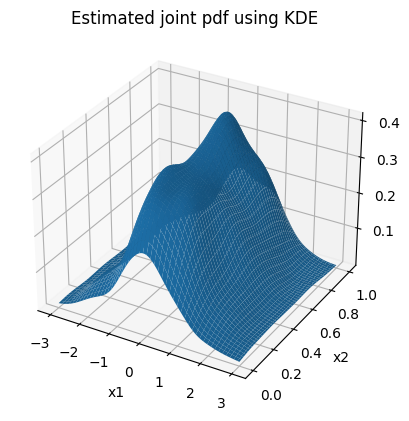

In [5]:
# plot estimated pdf
x=np.linspace(-3,3,100)
y=np.linspace(0,1,100)
X, Y = np.meshgrid(x,y)
z = np.array([kde.pdf([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z)
plt.title('Estimated joint pdf using KDE')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()